# Comparing mouse behavior to HMM

## This notebook extracts the following behavioral features to compare with the HMM model:

1. probability/rate of choosing 'correct' port at the end of a block (ie at its most stable point)
2. time constant of rate/probability of choosing the 'correct' port following a block switch
3. peak probability/rate of switching at the beginning of a block

Approach:

1. load in feature matrix for each session
2. Try and extract the 3 features and append columns to a copy of the record DB
3. Calculate averages for each condition & mouse
4. store in dataframe <-- maybe want to do some filtering here to take out really bad performances?


In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import os
from scipy import optimize
%matplotlib inline 

## function *extract_session_stats(data)*
Takes in a feature matrix and returns the 3 stats we want to compare to the hmm

In [2]:
def extract_session_stats(data):
    '''
    Inputs:
        data - (pandas dataframe) feature matrix (reduced or not)
    
    Outputs:
        dataframe with 3 columns:
            stable_phigh- prob/rate of choosing high p port at end of block (last 10 trials)
            peak_pswitch- prob/rate of switching at beginning of block (first 10 trials)
            rebias_tau-   time constant of exponential function fit to p(high p port) after block switch
    '''
    
    
    #all the block numbers
    t_block_unique = np.unique(data['Block Trial'].values)

    # initialize matrix for p(switch) at every trial number in block. 2nd column for SEM
    p_switch_block = np.zeros((t_block_unique.shape[0],2))

    # initialize matrix for p(high_p_port)
    high_p_port = np.zeros_like(p_switch_block)

    '''
    calculate p(switch) for each trial # in block (from 0 -> end)
    '''
    for t in t_block_unique:
        switches = data[data['Block Trial'] == t]['Switch']
        p_switch_block[t,0] = switches.mean(axis=0)
        p_switch_block[t,1] = switches.std(axis=0) / np.sqrt(switches.shape[0])
        
        highport = data[data['Block Trial']==t]['Higher p port']
        high_p_port[t,0] = highport.mean(axis=0)
        high_p_port[t,1] = highport.std(axis=0) / np.sqrt(highport.shape[0])


    '''
    calculate p(switch) and p(high port) for trial #s in block (from -L to +L)
    '''

    data.index = np.arange(data.shape[0]) # <-- this is important
    switch_points = data[data['Block Trial'] == 0].index.values

    L = 30
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 1))
    paraswitch_port = np.zeros_like(paraswitch)

    for i,point in enumerate(switch_points):
        try:
            paraswitch[i,:] = data.iloc[point-L:point+L+1]['Switch']
            paraswitch_port[i,:] = data.iloc[point-L:point+L+1]['Higher p port']
        except:
            pass

    '''
    calculate exponential fit for p(high port) after block switch
    '''
    #first define exponential function to be optimized
    def exp_func(x,a,b,c):
        return a*np.exp(-b*x) + c
    
    #fit curve
    popt,pcov = optimize.curve_fit(exp_func,np.arange(L+1),paraswitch_port.mean(axis=0)[L:])
    
    #calc peak_switch, stable_phigh, and tau
    peak_switch = paraswitch[:,L:L+10].mean(axis=0).max()
    stable_phigh = paraswitch_port[:,L-10:L].mean()
    rebias_tau = 1./popt[1]
    
    d = {'stable_phigh':stable_phigh,'peak_pswitch':peak_switch,'rebias_tau':rebias_tau}
    
    return pd.DataFrame(data=d,index=[0])

## Load in data database

We don't want to consider *every* session. Let's make the following requirements:
1. It's in Phase 2 (not phase 1, which does not require switches)
2. No. Blocks >= 4
3. No. Rewards > 100
4. p(high Port) > 0.5

In [3]:
#load in data base
db = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/session_record.csv',index_col=0)

'''
select the sessions we want
'''

#only phase 2
db_s = db[(db['Phase'] == 2)].copy()
# No. Blocks >= 4
#db_s = db_s[db_s['No. Blocks'] >= 4].copy()
# No. Rewards > 100
#db_s = db_s[db_s['No. Rewards'] > 100].copy()
# p(high Port) 0.5
#db_s = db_s[db_s['p(high Port)'] > 0.5].copy()
# only 50 reward blocks
db_s = db_s[db_s['Block Range Min'] == 50].copy()

session_names = db_s['Session ID'].values
mouse_ids = db_s['Mouse ID'].values
session_ids = db_s['Session ID'].values
dates = db_s['Date'].values
conditions = db_s['Left Reward Prob'].values
phigh = db_s['p(high Port)'].values
nrewards = db_s['No. Rewards'].values

In [4]:
root_dir = '/Users/shayneufeld/GitHub/mouse_bandit/data/feature_data'
failures = []
for i,session in enumerate(session_ids):
    
    #load in the feature matrix
    full_name = session + '_features.csv'
    path_name = os.path.join(root_dir,full_name)
    session_matrix = pd.read_csv(path_name,index_col=0)
    #try calculating the stats with extract_stats
    try:
        stats = extract_session_stats(session_matrix)

        #append them to a master dataframe
        stats['Mouse ID'] = mouse_ids[i]
        stats['Date'] = dates[i]
        stats['Condition'] = conditions[i]
        stats['p(high Port)'] = phigh[i]
        stats['No. Rewards'] = nrewards[i]

        if i == 0:
            stats_df = stats.copy()
        else:
            stats_df = stats_df.append(stats)
    
    except:
        failures.append(session)
        

//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/CaGRIN/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [5]:
#clean up conditions
stats_df['Condition'] = stats_df['Condition'].replace(to_replace=0,value=1.0)
stats_df['Condition'] = stats_df['Condition'].replace(to_replace=0.1,value=0.9)
stats_df['Condition'] = stats_df['Condition'].replace(to_replace=0.2,value=0.8)
stats_df['Condition'] = stats_df['Condition'].replace(to_replace=0.3,value=0.7)

## Data visualization

start with Dumble. 
track his performance over days, 

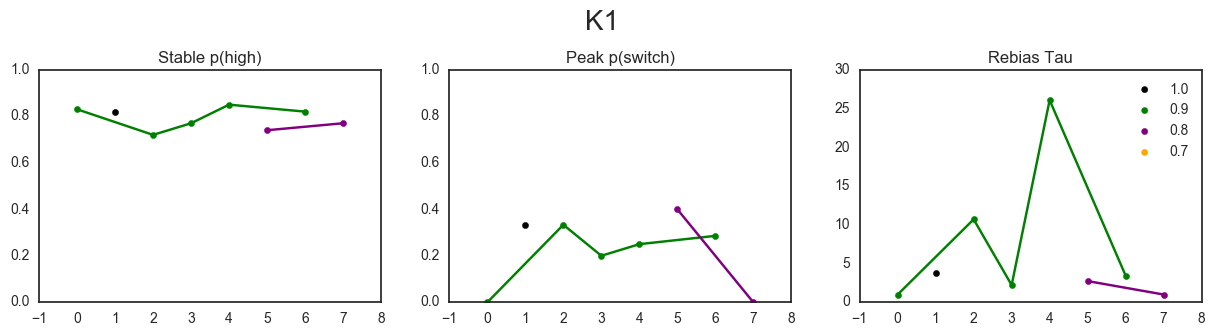

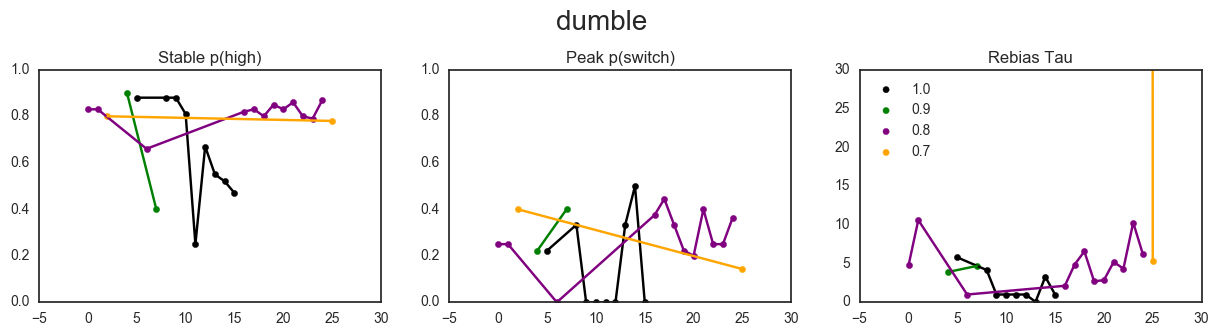

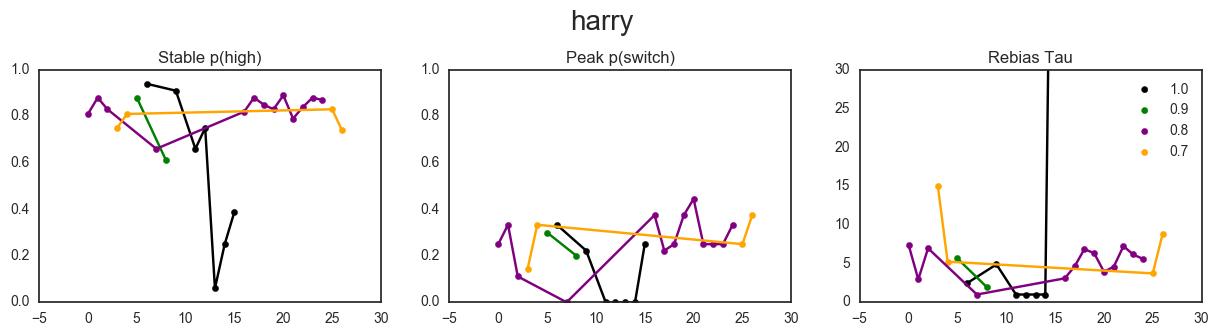

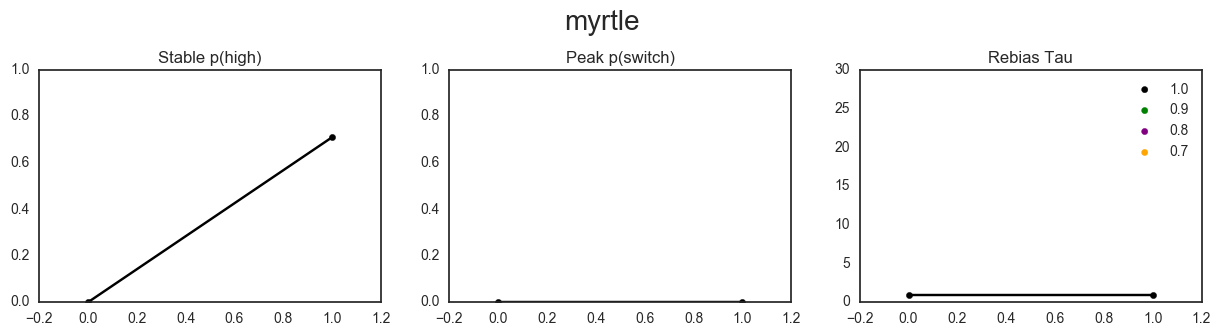

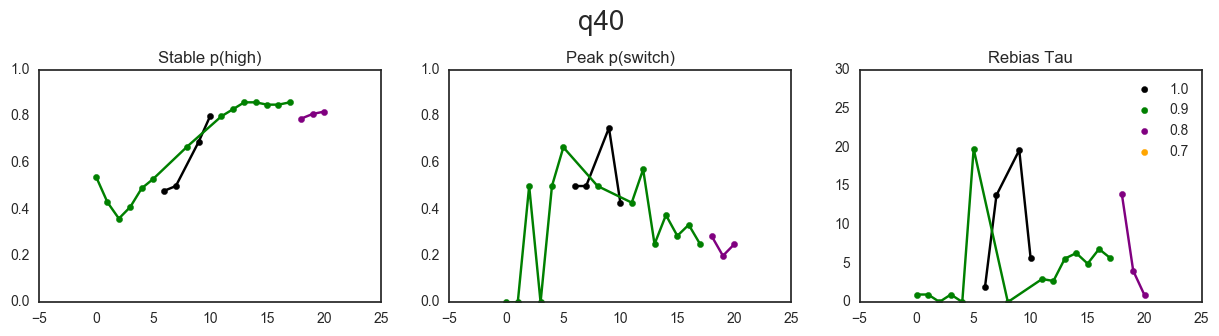

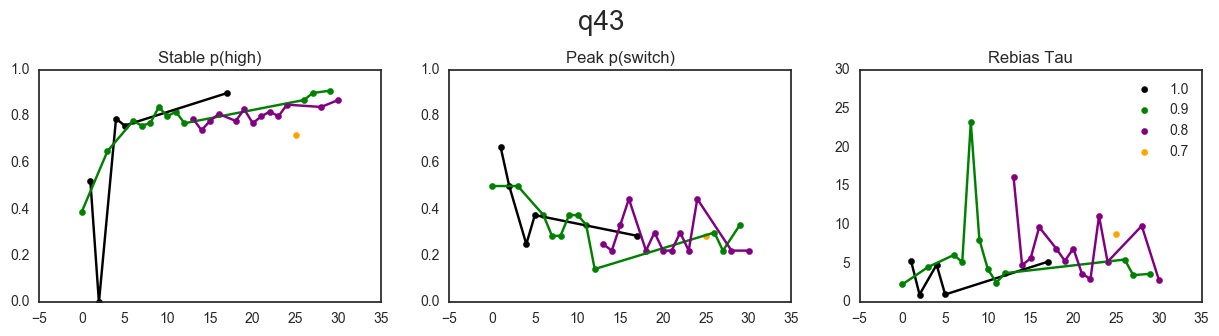

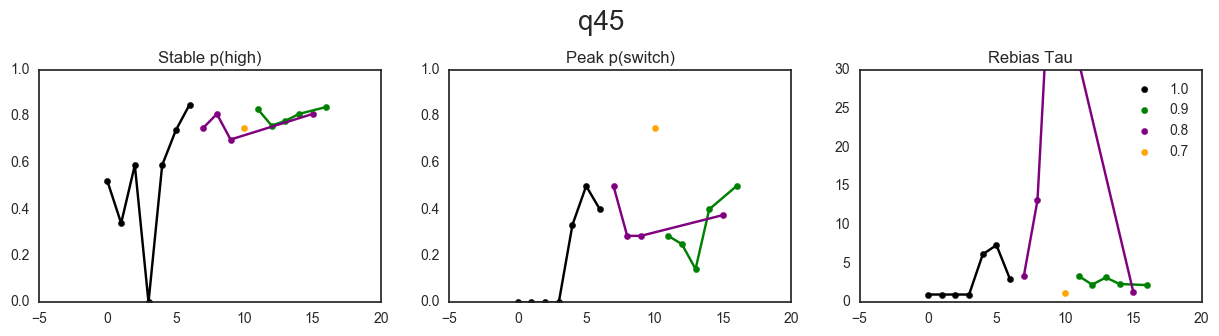

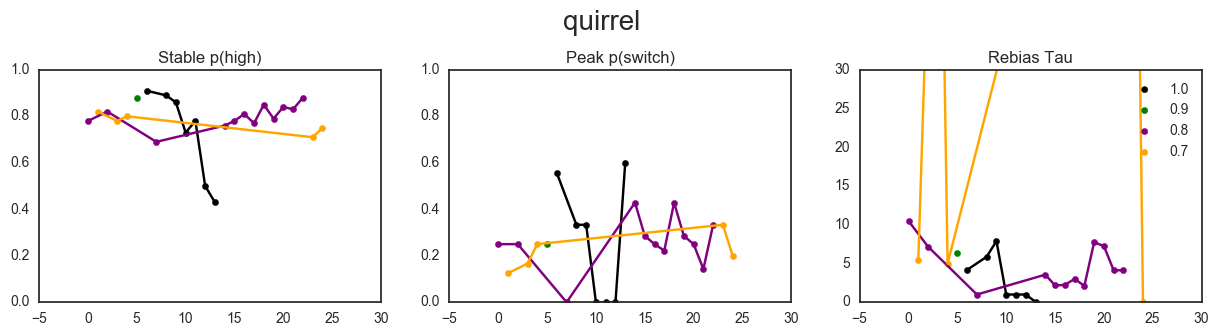

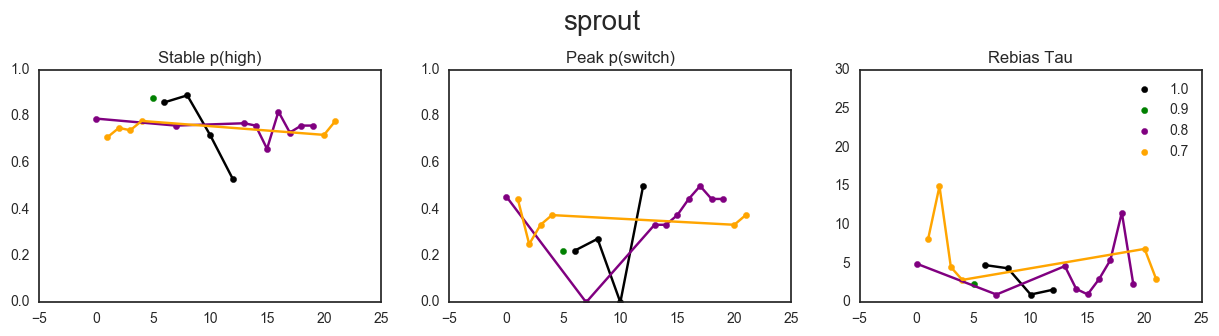

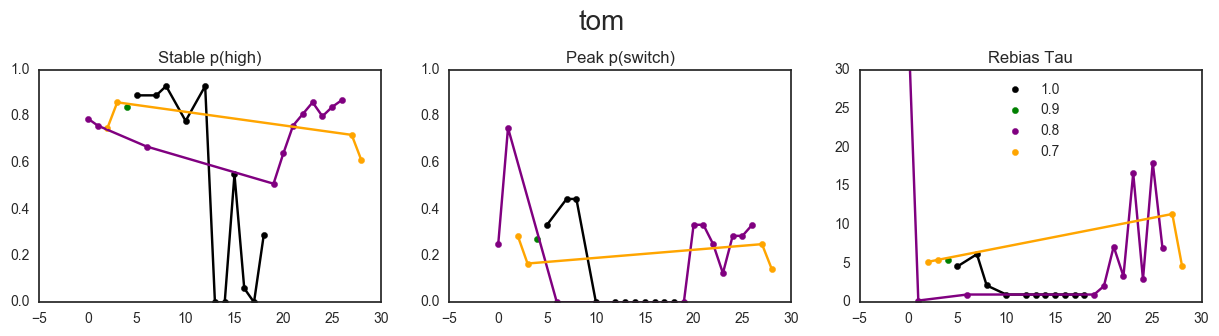

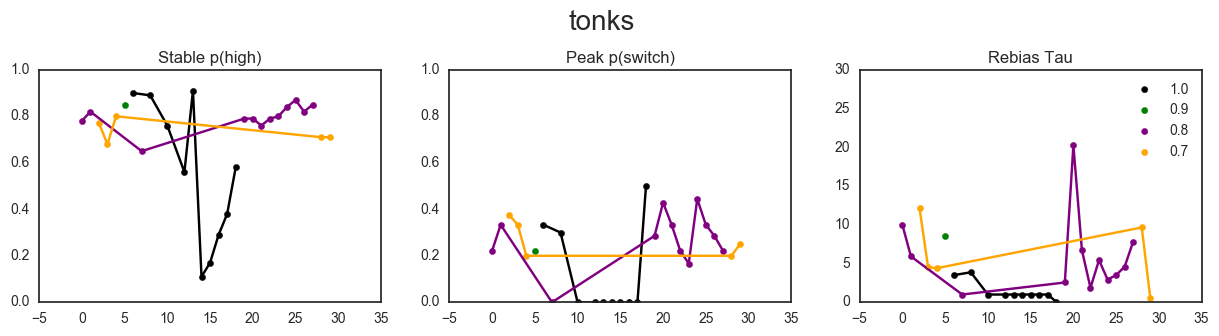

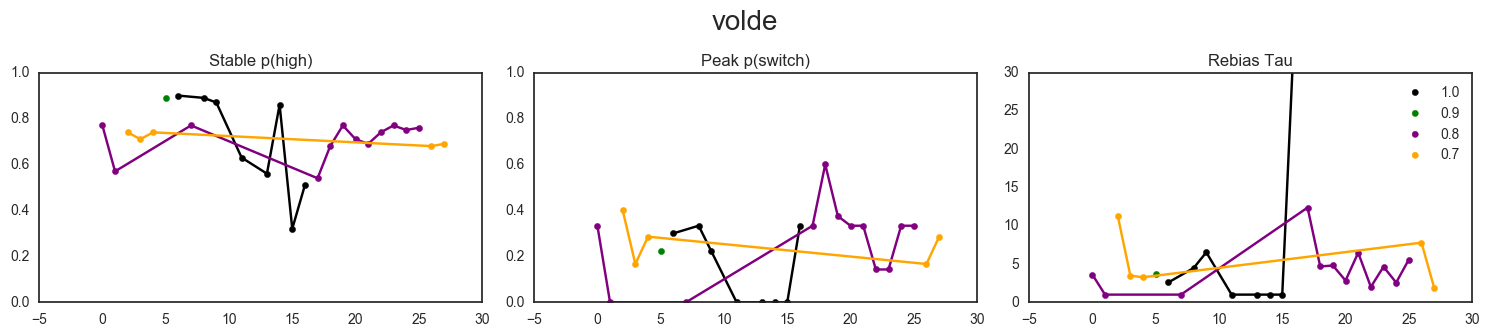

In [9]:
sns.set_style('white')
mice = np.unique(stats_df['Mouse ID'].values)

for mouse in mice:
    d = stats_df[stats_df['Mouse ID'] == mouse].copy()
    d.index = np.arange(d.shape[0])
    plt.figure(figsize=(15,3))
    plt.suptitle(mouse,fontsize=20,x=0.5,y=1.1)
    colors = ['black','green','purple','orange']
    for i,c in enumerate([1.0,0.9,0.8,0.7]):
        dates = d[d['Condition']==c]['Date'].values
        dates = dates.astype('str')
        x = d[d['Condition']==c].index.values

        h1 = plt.subplot(131)
        plt.plot(x,d[d['Condition']==c]['p(high Port)'].values,color=colors[i])
        plt.scatter(x,d[d['Condition']==c]['p(high Port)'].values,label=c,color=colors[i])
        plt.ylim(0,1)
        plt.title('Stable p(high)')

        h2 = plt.subplot(132)
        plt.plot(x,d[d['Condition']==c]['peak_pswitch'].values,color=colors[i])
        plt.scatter(x,d[d['Condition']==c]['peak_pswitch'].values,label=c,color=colors[i])
        plt.ylim(0,1)
        plt.title('Peak p(switch)')

        h3 = plt.subplot(133)
        plt.plot(x,d[d['Condition']==c]['rebias_tau'].values,color=colors[i])
        plt.scatter(x,d[d['Condition']==c]['rebias_tau'].values,label=c,color=colors[i])
        plt.ylim(0,30)
        plt.title('Rebias Tau')

    #h1.set_xticklabels(q43['Date'].values,rotation='vertical')
    #h2.set_xticklabels(q43['Date'].values,rotation='vertical')
    #h3.set_xticklabels(q43['Date'].values,rotation='vertical')
    plt.legend(loc='best')
plt.tight_layout()

In [7]:
q43['Date'].values

NameError: name 'q43' is not defined

In [ ]:
stats_90 = stats_df[stats_df['Condition']==0.9].copy()
stats_80 = stats_df[stats_df['Condition']==0.8].copy()
stats_70 = stats_df[stats_df['Condition']==0.7].copy()

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle('prob choose high port',fontsize=20,x=0.5,y=1.1)
for i,s in enumerate([stats_90,stats_80,stats_70]):
    plt.subplot(1,3,i+1)
    sns.boxplot(x='Mouse ID',y='p(high Port)',data=s)
    plt.ylim(0.5,1)
plt.tight_layout()